## 编码器和解码器

In [2]:
from torch import nn

class Encoder(nn.Module):
    """编码器-解码器结构的基本编码器接口。"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [3]:
class Decoder(nn.Module):
    """编码器-解码器结构的基本解码器接口。"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [4]:
class EncoderDecoder(nn.Module):
    """编码器-解码器结构的基类。"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## seq2seq

In [8]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [20]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        print('encoder X dimension', X.shape)
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        print('encoder output dimension', output.shape)
        print('encoder state dimension', state.shape)
        
        
        return output, state

In [9]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [11]:
state.shape

torch.Size([2, 4, 16])

In [21]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        print('decoder X dimension', X.shape)
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        print('decoder output dimension', output.shape)
        return output, state

In [12]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [17]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项。"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
#     print('mask', mask)
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [18]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""

    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [ ]:
# Double check
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

In [15]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型。"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    
    # net is the encoderdecoder, flag the training phrase
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            ## orignal sentence X 
            ## target sentence Y
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

encoder X dimension torch.Size([64, 10, 32])
encoder output dimension torch.Size([10, 64, 32])
encoder state dimension torch.Size([2, 64, 32])
decoder X dimension torch.Size([10, 64, 32])
decoder output dimension torch.Size([64, 10, 201])
encoder X dimension torch.Size([64, 10, 32])
encoder output dimension torch.Size([10, 64, 32])
encoder state dimension torch.Size([2, 64, 32])
decoder X dimension torch.Size([10, 64, 32])
decoder output dimension torch.Size([64, 10, 201])
encoder X dimension torch.Size([64, 10, 32])
encoder output dimension torch.Size([10, 64, 32])
encoder state dimension torch.Size([2, 64, 32])
decoder X dimension torch.Size([10, 64, 32])
decoder output dimension torch.Size([64, 10, 201])
encoder X dimension torch.Size([64, 10, 32])
encoder output dimension torch.Size([10, 64, 32])
encoder state dimension torch.Size([2, 64, 32])
decoder X dimension torch.Size([10, 64, 32])
decoder output dimension torch.Size([64, 10, 201])
encoder X dimension torch.Size([64, 10, 32])

encoder X dimension torch.Size([64, 10, 32])
encoder output dimension torch.Size([10, 64, 32])
encoder state dimension torch.Size([2, 64, 32])
decoder X dimension torch.Size([10, 64, 32])
decoder output dimension torch.Size([64, 10, 201])
encoder X dimension torch.Size([64, 10, 32])
encoder output dimension torch.Size([10, 64, 32])
encoder state dimension torch.Size([2, 64, 32])
decoder X dimension torch.Size([10, 64, 32])
decoder output dimension torch.Size([64, 10, 201])
encoder X dimension torch.Size([64, 10, 32])
encoder output dimension torch.Size([10, 64, 32])
encoder state dimension torch.Size([2, 64, 32])
decoder X dimension torch.Size([10, 64, 32])
decoder output dimension torch.Size([64, 10, 201])
encoder X dimension torch.Size([64, 10, 32])
encoder output dimension torch.Size([10, 64, 32])
encoder state dimension torch.Size([2, 64, 32])
decoder X dimension torch.Size([10, 64, 32])
decoder output dimension torch.Size([64, 10, 201])


KeyboardInterrupt: 

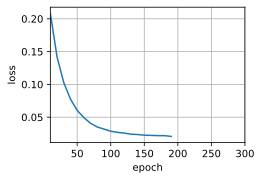

In [23]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)